In [ ]:
!pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

# **Bellman Ford с одной стартовой вершиной**

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
* Функция принимает представление графа, удобное для неё (загрузка, конвертация
реализованы отдельно) и номер стартовой вершины.
* Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [ ]:
# ошибка присутсвия цикла орицательного веса

class NegativeWeightError(Exception):
    print("Присутсвует цикл отрицательного веса")

Присутсвует цикл отрицательного веса


In [ ]:
def Bellman_Ford(A, vertex):
  # количество вершин
  m = A.nrows
  # создаем вектор и инициализируем начальную вершину с нулевым расстоянием
  v = Vector(A.dtype, m)
  v[vertex] << 0
  # реализуем алгоритм обхода графа
  w = v.dup()
  for i in range(m - 1):
      # данные по расстоянию копируем в новый вектор
      w_old = w.dup()
      # обновляем расстояния
      w(binary.min) << w.vxm(A, semiring.min_plus)
      # алгоритм работает до тех пор, пока на каком-либо шаге расстояния не перестанут меняться
      if w.isequal(w_old):
        break
  # проверяем на наличие циклов отрицательного веса
  w_old = w.dup()
  w(binary.min) << w.vxm(A, semiring.min_plus)
  # при наличие выводим ошибку с сообщением
  if not w.isequal(w_old):
    raise NegativeWeightError("Присутсвует цикл отрицательного веса")
  #формирую ответ
  final = []
  for i in range(m):
    # если вершина недостижима, то значение 'inf'
    if w[i].value is None:
        final.append(float('inf'))
    # формируем массив с расстояниями от стартовой вершины до остальных
    else:
        final.append(w[i].value)
  return final

# **Bellman Ford с несколькими стартовыми вершинами**

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
* Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
*  Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [ ]:
def Bellman_Ford_new(A, massiv):
  # количество вершин в графе
  n = A.ncols
  # количество стартовых вершин
  m = len(massiv)
  # создаем матрицу и инициализируем начальные вершины с нулевым расстоянием
  v = Matrix(dtypes.UINT32, m, n)
  for i in range(m):
    v[i, massiv[i]] << 0
  # реализуем алгоритм обхода графа
  w = v.dup()
  for i in range(n - 1):
    w_old = w.dup()
    for i in range(m):
      w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
    if w.isequal(w_old):
        break
  # проверяем на наличие циклов отрицательного веса
  w_old = w.dup()
  for i in range(m):
    w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
  if not w.isequal(w_old):
    raise NegativeWeightError("Присутсвует цикл отрицательного веса")
  # если все ок, то формируем ответ
  # расстояния помещаем в массив пар final
  final = {}
  for i in range(m):
    values = []
    for j in range(n):
      # если вершина недостижима, то значение 'inf'
      if w[i, j].value is None:
        values.append(float('inf'))
        # формируем массив с расстояниями от стартовой вершины до остальных
      else:
        values.append(w[i, j].value)
    final[massiv[i]] = (values)
  return final

# **Тестирование**

Тесты для проверки корректности полученных реализаций.


**TEST 1**

Граф, где в каждую вершину можно папость из любой вершины.

Проверим, что вес берется в расчет при нахождение кратчайших путей.

*Например, из вершины "2" можно попасть в "3" перейдя по связанному их ребру, но вес там 5. Алгоритм должен найти кратчайший путь до "3" из "2" через вершину "1", где вес будет составлять 3.*

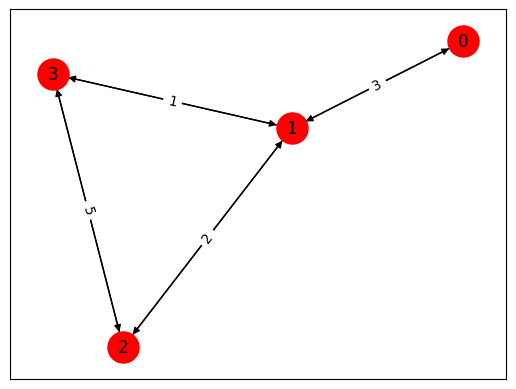

In [ ]:
data = [
    [0, 1, 1, 2, 2, 3, 1, 3],
    [1, 0, 2, 1, 3, 1, 3, 2],
    [3, 3, 2, 2, 5, 1, 1, 5],
]
rows, cols, weights = data
M1 = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(M1)

In [ ]:
# стартовая вершина 0 и 0, 1, 2
p1 = 0
p2 = [0, 1, 2]
# правильные ответы
a1 = [0, 3, 5, 4]
a2 = {0: [0, 3, 5, 4], 1: [3, 0, 2, 1], 2: [5, 2, 0, 3]}

print('Bellman_Ford:', Bellman_Ford(M1, p1))
print('Bellman_Ford_new:', Bellman_Ford_new(M1, p2))

if Bellman_Ford(M1, p1) == a1 and Bellman_Ford_new(M1, p2) == a2:
  print('Test passed')
else:
  print('Test failed')

Bellman_Ford: [0, 3, 5, 4]
Bellman_Ford_new: {0: [0, 3, 5, 4], 1: [3, 0, 2, 1], 2: [5, 2, 0, 3]}
Test passed


**TEST 2**

Немного изменим предыдущий граф, теперь из вершины "1" нельзя попасть в вершину "3" по прямой.

*Проверим, что алгоритм пройдет в вершину "3" через вершину "2". А из вершины "3" в вершину "1" по прямой веса 1.*

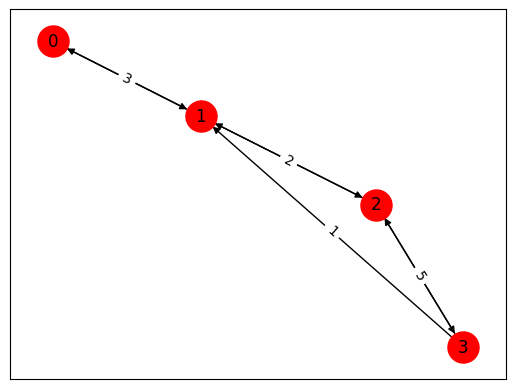

In [ ]:
data = [
    [0, 1, 1, 2, 2, 3, 3],
    [1, 0, 2, 1, 3, 1, 2],
    [3, 3, 2, 2, 5, 1, 5],
]
rows, cols, weights = data
M2 = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(M2)

In [ ]:
# стартовая вершина 1 и 0, 1, 3
p1 = 1
p2 = [0, 1, 3]
# правильные ответы
a1 = [3, 0, 2, 7]
a2 = {0: [0, 3, 5, 10], 1: [3, 0, 2, 7], 3: [4, 1, 3, 0]}

print('Bellman_Ford:', Bellman_Ford(M2, p1))
print('Bellman_Ford_new:', Bellman_Ford_new(M2, p2))

if Bellman_Ford(M2, p1) == a1 and Bellman_Ford_new(M2, p2) == a2:
  print('Test passed')
else:
  print('Test failed')

Bellman_Ford: [3, 0, 2, 7]
Bellman_Ford_new: {0: [0, 3, 5, 10], 1: [3, 0, 2, 7], 3: [4, 1, 3, 0]}
Test passed


**TEST 3**

Исправим теперь веса на том же графе на отрицательные.

*Проверим, что алгоритм вернет созданную ранее ошибку NegativeWeightError.*

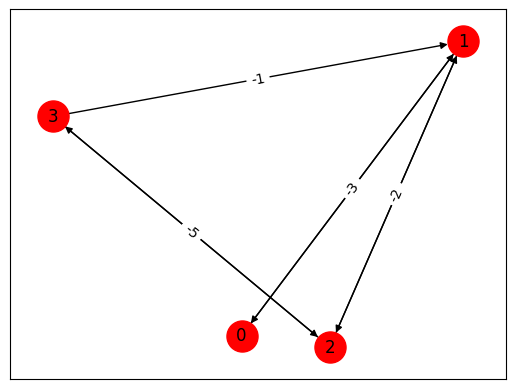

In [ ]:
data = [
    [0, 1, 1, 2, 2, 3, 3],
    [1, 0, 2, 1, 3, 1, 2],
    [-3, -3, -2, -2, -5, -1, -5],
]
rows, cols, weights = data
M3 = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(M3)

In [ ]:
# стартовая вершина 0
p1 = 0

Bellman_Ford(M3, p1)

NegativeWeightError: Присутсвует цикл отрицательного веса

In [ ]:
# стартовая вершина 0, 1
p1 = np.array([0, 1])

Bellman_Ford_new(M3, p1)

NegativeWeightError: Присутсвует цикл отрицательного веса

# **Дополнительно**

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).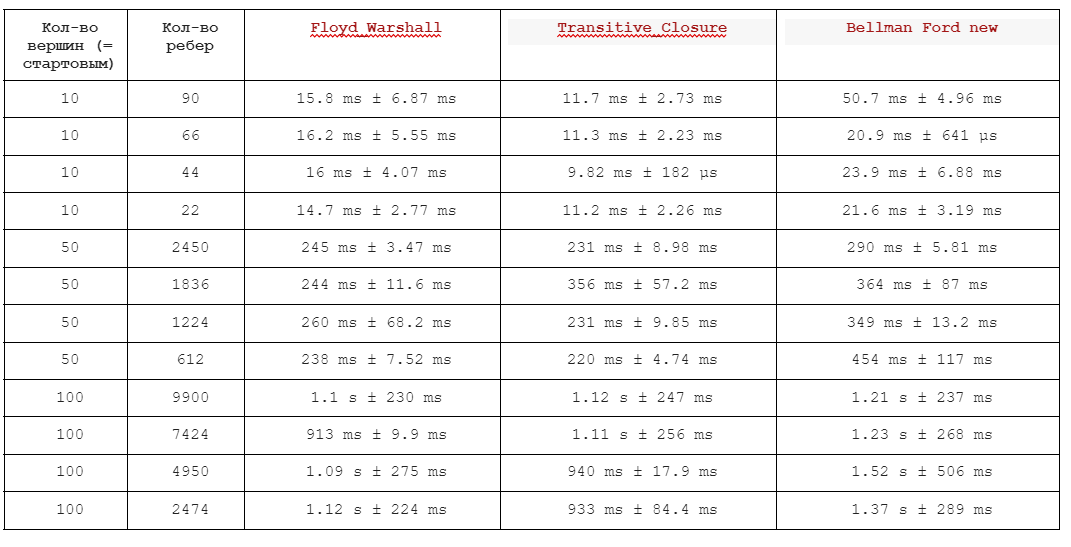

In [ ]:
import random
from graphblas.io import mmread

**Тестирование на больших графах с сайта SuiteSparse Matrix Collection**

In [ ]:
# читаем 3 графа
graph1 = mmread('/content/can_838.mtx')
graph2 = mmread('/content/dwt_992.mtx')
graph3 = mmread('/content/can_1054.mtx')

# создаем массив графов
graphs = [graph1, graph2, graph3]

In [ ]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time(A, a):
  print('Bellman_Ford:')
  %timeit Bellman_Ford(A, a)

def alg_time2(A, a):
  print('Bellman_Ford_new:')
  %timeit Bellman_Ford_new(A, a)

In [ ]:
# создаем функцию для генерации массива стартовых вершин, где n - количество вершин в графе и p - доля генерируемых стартовых вершин
def vertex_generate(n, p):
  population = range(n)
  vertex_array = random.sample(population, round(n * p))
  return np.array(vertex_array)

In [ ]:
# Выводим нужные нам данные для сравнения результатов

vertex = [1]
gen_vertex = [0.01, 0.05, 0.1, 0.5] # доля генерируемых вершин
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  print('Количество стартовых вершин:', vertex)
  print(alg_time(k, vertex))
  print(alg_time2(k, vertex))
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: [1]
Bellman_Ford:
81.7 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford_new:
95 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford_new:
854 ms ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford_new:
3.58 s ± 513 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 84
Bellman_Ford_new:
7.21 s ± 473 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 419
Bellman_Ford_new:
36.2 s ± 721 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: [1]
Bellman_Ford:
75.4 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford_new:
95.7 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loop

In [ ]:
# Выводим нужные нам данные для сравнения результатов

vertex = [[1, 5], [10, 5, 85], [22, 53, 4, 51] ]
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  for p in vertex:
    print('Количество стартовых вершин:', len(p))
    print(alg_time2(k, p))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: 2
Bellman_Ford_new:
153 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 3
Bellman_Ford_new:
338 ms ± 67.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 4
Bellman_Ford_new:
348 ms ± 80.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: 2
Bellman_Ford_new:
227 ms ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 3
Bellman_Ford_new:
286 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 4
Bellman_Ford_new:
380 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1054 Количество ребер: 12196
Количество стартовых вершин: 2
Bellman_Ford_new:
308 ms ± 8.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Коли

In [ ]:
vertex = [[1, 5], [10, 5, 85], [22, 53, 4, 51]]
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  for p in vertex:
    for i in p:
      print(alg_time(k, i))

Количество вершин: 838 Количество ребер: 10010
Bellman_Ford:
74.1 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
56.9 ms ± 720 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
68 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
94.8 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Bellman_Ford:
56.6 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
56.9 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
74.2 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
56.9 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
64 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 992 Количество ребер: 16744
Bellman_Ford:
71.5 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Bellman_Ford:
69.

**Тестирование на случайно сгенерированных графах с использованием реализации с прошлой лабораторной работы**

In [ ]:
# n_rows - количество вершин графа, density - условно, насколько матрица смежности разряженная
def graph_generator(n_rows, density):
  # создание пустой матрицы размера n_rows на n_rows
  A = gb.Matrix(int, n_rows, n_rows)
  # ограничение на количество итераций
  while density > 0:
      # генерация рандомных чисел для матрицы смежности в интервале от 0 до количества ребер -1
      i = random.randint(0, n_rows - 1)
      j = random.randint(0, n_rows - 1)
      # проверка, что для данной ячеки еще не генерировались значения
      if A.get(i,j) is None and i != j:
          # заполнение матрицы смежности - записываем '1' в ячейку с только что сгенерированными числами и в смежную ей ячейку
          weight = random.randint(0, 10)
          A[i,j] = weight
          A[j,i] = weight
          density = density - 1
  return A

In [ ]:
# 10 vertexes
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print('Количество стартовых вершин:', vertex)
  print(alg_time(k, vertex))
  print(alg_time2(k, vertex))
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 10 количество ребер: 90
Количество стартовых вершин: [1]
Bellman_Ford:
1.56 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Bellman_Ford_new:
2.46 ms ± 85.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 1
Bellman_Ford_new:
2.79 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 3
Bellman_Ford_new:
7.92 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
Bellman_Ford_new:
18.6 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 66
Количество стартовых вершин: [1]
Bellman_Ford:
1.47 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Bellman_Ford_new:
2.66 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 1
Bellman_Ford_new:
2.33 ms ± 59.2 µs per loop (mean ± std. dev. of 7 r

In [ ]:
# 10 vertexes
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 10 количество ребер: 90
Количество стартовых вершин: 8
Bellman_Ford_new:
22.4 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford_new:
33.1 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford_new:
50.7 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 10 количество ребер: 66
Количество стартовых вершин: 8
Bellman_Ford_new:
29.4 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford_new:
19.7 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford_new:
20.9 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 10 количество ребер: 44
Количество стартовых вершин: 8
Bellman_Ford_new:
19 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
# 50 vertexes
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print('Количество стартовых вершин:', vertex)
  print(alg_time(k, vertex))
  print(alg_time2(k, vertex))
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 50 количество ребер: 2450
Количество стартовых вершин: [1]
Bellman_Ford:
4.51 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Bellman_Ford_new:
7.06 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
Bellman_Ford_new:
47.5 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
Bellman_Ford_new:
91.8 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 25
Bellman_Ford_new:
169 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 50 количество ребер: 1836
Количество стартовых вершин: [1]
Bellman_Ford:
6.31 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Bellman_Ford_new:
6.87 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
Bellman_Ford_new:
32 ms ± 1.68 ms per loop (mean ± std. dev. of 7 ru

In [ ]:
# 50 vertexes
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)

  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 50 количество ребер: 2450
Количество стартовых вершин: 38
Bellman_Ford_new:
366 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford_new:
249 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford_new:
290 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1836
Количество стартовых вершин: 38
Bellman_Ford_new:
231 ms ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford_new:
254 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford_new:
364 ms ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1224
Количество стартовых вершин: 38
Bellman_Ford_new:
374 ms ± 89.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количе

In [ ]:
# 100 vertexes
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.1, 0.3, 0.5] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print('Количество стартовых вершин:', vertex)
  print(alg_time(k, vertex))
  print(alg_time2(k, vertex))
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 100 количество ребер: 9900
Количество стартовых вершин: [1]
Bellman_Ford:
9.56 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Bellman_Ford_new:
10.9 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford_new:
116 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 30
Bellman_Ford_new:
308 ms ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford_new:
752 ms ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Количество стартовых вершин: [1]
Bellman_Ford:
8.08 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Bellman_Ford_new:
13.4 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford_new:
128 ms ± 26.7 ms per loop (mean ± std. dev. of 7 run

In [ ]:
# 100 vertexes
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 100 количество ребер: 9900
Количество стартовых вершин: 75
Bellman_Ford_new:
779 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 85
Bellman_Ford_new:
980 ms ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 100
Bellman_Ford_new:
1.21 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Количество стартовых вершин: 75
Bellman_Ford_new:
782 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 85
Bellman_Ford_new:
1.08 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 100
Bellman_Ford_new:
1.23 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 4950
Количество стартовых вершин: 75
Bellman_Ford_new:
849 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Колич

Результаты тестирования алгоритмов по [ссылке](https://docs.google.com/document/d/1HkwUq6W-e53jyKa7eXlu_3q2DDyeHIq-EZs9QGwxaBA/edit?usp=sharing).

**Выводы:**

1. Судя по тестированию на реальных графах, модифицированный алгоритм Беллмана Форда эффективнее использовать на больших графах, причем используя его, когда стартовых вершин ~более 1% от всех вершин графа. Так, например в графе с 838 вершинами модифицированный алгоритм немного быстрее уже при вязтие 8 стартовых вершин, а при взятие половины вершин как стартовых, классический алгоритм медленне аж в 15 раз.
2. На больших реальных графах с одной стартовой вершиной быстрее работает классический алгоритм,также при взятие 2-4 вершин классический алгоритм оказался немного быстрее, хотя в графе с 1054 вершинами при 4 стартовых вершинах модифицированный алгоритм уже ведет себя быстрее.

3. Тестирование на случайно сгенерированных графах показывает, что на малых графах эффективнее использовать классический алгоритм (в тестирование были графы до 100 вершин). Причем по тестам разряженность графа не особо влияет на работу алгоритмов.
4. Что касается количества стартовых вершин, даже при увеличение количества стартовых вершин классический алгоритм все еще показывает себя быстрее. Дополнительно было проверено будет ли выигрывать по времени модифицированный алгоритм, если взять 100% вершин в этих малых графах, но как выяснилось, по времени он все-таки слегка проигрывает. Поэтому, скорее всего с увеличением количество вершин в графе более 100 модифицированный алгоритм будет эффективнее, чем классический.

Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (**Floyd–Warshall и вычисление транзитивного замыкания**).
* Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
* Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

# **Floyd Warshall**

In [ ]:
def Floyd_Warshall(A):
  # количество вершин в графе
  n = A.nrows
  w = A.dup()
  w_cur = A.dup()
  # реализуем алгоритм обхода графа
  for i in range(n):
    #  матрицы для рреализации умножения
    w_c = Matrix(dtypes.INT32, n, n)
    w_r = Matrix(dtypes.INT32, n, n)
    # заполнение
    w_c[:, i] = w[:, i].dup()
    w_r[i, :] = w[i, :].dup()
    # обновляем расстояния
    w_cur << w_c.mxm(w_r, semiring.min_plus)
    w << w.ewise_add(w_cur, op="min")
  # проверяем на наличие циклов отрицательного веса
  weight = w.dup()
  weight_cur = w_cur.dup()
  weight_c = Matrix(dtypes.INT32, n, n)
  weight_r = Matrix(dtypes.INT32, n, n)
  weight_c[:, i] = weight[:, i].dup()
  weight_r[i, :] = weight[i, :].dup()
  weight_cur << weight_c.mxm(weight_r, semiring.min_plus)
  weight << weight.ewise_add(weight_cur, op="min")
  if not weight.isequal(w):
    raise NegativeWeightError("Присутсвует цикл отрицательного веса")
  # если все ок, то формируем ответ
  # расстояния помещаем в массив пар final
  final = {}
  for i in range(n):
    values = []
    for j in range(n):
      if i == j:
        values.append(0)
      elif w[i,j].value is None:
        values.append(float('inf'))
      else:
        values.append(w[i,j].value)
    final[i] = values
  return final

# **Транзитивное замыкание**

In [ ]:
def Transitive_Closure(A):
  # количество вершин в графе
  n = A.ncols
  # создаем единичную матрицу, которая облегчит вычисления
  I = Matrix(dtypes.INT32, n, n)
  # заполним матрицу единичками
  for i in range(n):
    I[i, i] << 1
  w = I.dup()
  # реализуем алгоритм обхода графа
  for i in range(n):
    new_w = w.dup()
    w << w.mxm(A, semiring.min_plus).ewise_add(I, binary.min)
    if w.isequal(new_w):
       break
  # проверяем на наличие циклов отрицательного веса
  w_old = w.dup()
  w_old << w_old.mxm(A, semiring.min_plus).ewise_add(I, binary.min)
  if not w.isequal(w_old):
        raise NegativeWeightError("Присутсвует цикл отрицательного веса")
  # если все ок, то формируем ответ
  # расстояния помещаем в массив пар final
  final = {}
  for i in range(n):
      values = []
      for j in range(n):
        if i == j:
          values.append(0)
        elif w[i, j].value is None:
          values.append(float('inf'))
        else:
          values.append(w[i, j].value - 1)
      final[i] = (values)
  return final

# **Тестирование**

Проведем тестирование на тех же графах, что в первой части лабораторной работы

**TEST 1**

Граф, где в каждую вершину можно папость из любой вершины.

Проверим, что вес берется в расчет при нахождение кратчайших путей.

*Например, из вершины "2" можно попасть в "3" перейдя по связанному их ребру, но вес там 5. Алгоритм должен найти кратчайший путь до "3" из "2" через вершину "1", где вес будет составлять 3.*

In [ ]:
# правильные ответы
a = {0: [0, 3, 5, 4], 1: [3, 0, 2, 1], 2: [5, 2, 0, 3], 3: [4, 1, 3, 0]}

print('floyd_warshall:', Floyd_Warshall(M1))
print('Transitive_Closure:', Transitive_Closure(M1))

if Floyd_Warshall(M1) == a and Transitive_Closure(M1) == a:
  print('Test passed')
else:
  print('Test failed')

floyd_warshall: {0: [0, 3, 5, 4], 1: [3, 0, 2, 1], 2: [5, 2, 0, 3], 3: [4, 1, 3, 0]}
Transitive_Closure: {0: [0, 3, 5, 4], 1: [3, 0, 2, 1], 2: [5, 2, 0, 3], 3: [4, 1, 3, 0]}
Test passed


**TEST 2**

Немного изменим предыдущий граф, теперь из вершины "1" нельзя попасть в вершину "3" по прямой.

*Проверим, что алгоритм пройдет в вершину "3" через вершину "2". А из вершины "3" в вершину "1" по прямой веса 1.*

In [ ]:
# правильные ответы
a = {0: [0, 3, 5, 10], 1: [3, 0, 2, 7], 2: [5, 2, 0, 5], 3: [4, 1, 3, 0]}

print('Floyd_Warshall:', Floyd_Warshall(M2))
print('Transitive_Closure:', Transitive_Closure(M2))

if Floyd_Warshall(M2) == a and Transitive_Closure(M2) == a:
  print('Test passed')
else:
  print('Test failed')

Floyd_Warshall: {0: [0, 3, 5, 10], 1: [3, 0, 2, 7], 2: [5, 2, 0, 5], 3: [4, 1, 3, 0]}
Transitive_Closure: {0: [0, 3, 5, 10], 1: [3, 0, 2, 7], 2: [5, 2, 0, 5], 3: [4, 1, 3, 0]}
Test passed


**TEST 3**

Исправим теперь веса на том же графе на отрицательные.

*Проверим, что алгоритм вернет созданную ранее ошибку NegativeWeightError.*

In [ ]:
Floyd_Warshall(M3)

NegativeWeightError: Присутсвует цикл отрицательного веса

In [ ]:
Transitive_Closure(M3)

NegativeWeightError: Присутсвует цикл отрицательного веса

**TEST 4**

Построим более сложный граф и сравним выведенные данные трех алгоритмов.

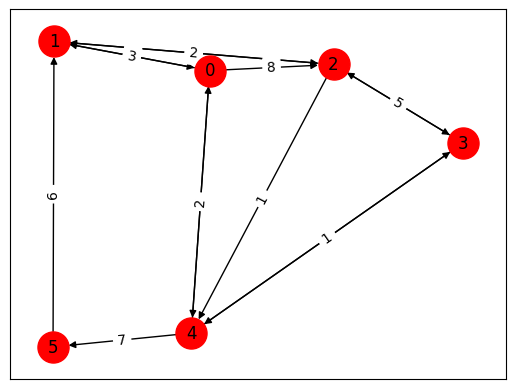

In [ ]:
data = [
    [0, 1, 1, 2, 2, 3, 0, 2, 0, 4, 4, 4, 3, 5],
    [1, 0, 2, 1, 3, 2, 2, 4, 4, 0, 5, 3, 4, 1],
    [3, 3, 2, 2, 5, 5, 8, 1, 2, 2, 7, 1, 1, 6],
]
rows, cols, weights = data
M4 = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(M4)

In [ ]:
# стартовые вершины для Bellman_Ford_new
p = [0, 1, 2, 3, 4, 5]

print('Bellman_Ford_new:', Bellman_Ford_new(M4, p))
print('Floyd_Warshall:', Floyd_Warshall(M4))
print('Transitive_Closure:', Transitive_Closure(M4))

if Bellman_Ford_new(M4, p) == Floyd_Warshall(M4) and  Bellman_Ford_new(M4, p) == Transitive_Closure(M4):
  print('Test passed')
else:
  print('Test failed')

Bellman_Ford_new: {0: [0, 3, 5, 3, 2, 9], 1: [3, 0, 2, 4, 3, 10], 2: [3, 2, 0, 2, 1, 8], 3: [3, 6, 5, 0, 1, 8], 4: [2, 5, 6, 1, 0, 7], 5: [9, 6, 8, 10, 9, 0]}
Floyd_Warshall: {0: [0, 3, 5, 3, 2, 9], 1: [3, 0, 2, 4, 3, 10], 2: [3, 2, 0, 2, 1, 8], 3: [3, 6, 5, 0, 1, 8], 4: [2, 5, 6, 1, 0, 7], 5: [9, 6, 8, 10, 9, 0]}
Transitive_Closure: {0: [0, 3, 5, 3, 2, 9], 1: [3, 0, 2, 4, 3, 10], 2: [3, 2, 0, 2, 1, 8], 3: [3, 6, 5, 0, 1, 8], 4: [2, 5, 6, 1, 0, 7], 5: [9, 6, 8, 10, 9, 0]}
Test passed


# **Дополнительно**

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [ ]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time3(A):
  print('Floyd_Warshall:')
  %timeit Floyd_Warshall(A)
  print('Transitive_Closure:')
  %timeit Transitive_Closure(A)

In [ ]:
# Выводим нужные нам данные для сравнения результатов

for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  print(alg_time3(k))

Количество вершин: 838 Количество ребер: 10010
Floyd_Warshall:
1min 15s ± 867 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
1min 9s ± 607 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Floyd_Warshall:
1min 50s ± 7.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
1min 39s ± 788 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1054 Количество ребер: 12196
Floyd_Warshall:
2min 3s ± 1.87 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
1min 50s ± 804 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [ ]:
# Выводим нужные нам данные для сравнения результатов

gen_vertex = [1] # доля генерируемых вершин
for k in graphs:
  print('Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: 838
Bellman_Ford_new:
1min 15s ± 522 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: 992
Bellman_Ford_new:
1min 56s ± 812 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1054 Количество ребер: 12196
Количество стартовых вершин: 1054
Bellman_Ford_new:
2min 12s ± 12.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [ ]:
# 10 vertexes
rows = 10
density = [45, 33, 22, 11]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print(alg_time3(k))

Количество вершин: 10 количество ребер: 90
Floyd_Warshall:
15.8 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Transitive_Closure:
11.7 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 66
Floyd_Warshall:
16.2 ms ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Transitive_Closure:
11.3 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 44
Floyd_Warshall:
16 ms ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Transitive_Closure:
9.82 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 количество ребер: 22
Floyd_Warshall:
14.7 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Transitive_Closure:
11.2 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None


In [ ]:
# 50 vertexes
rows = 50
density = [1225, 918, 612, 306]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print(alg_time3(k))

Количество вершин: 50 количество ребер: 2450
Floyd_Warshall:
245 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
231 ms ± 8.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1836
Floyd_Warshall:
244 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
356 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1224
Floyd_Warshall:
260 ms ± 68.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
231 ms ± 9.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 612
Floyd_Warshall:
238 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
220 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [ ]:
# 100 vertexes
rows = 100
density = [4950, 3712, 2475, 1237]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
  print(alg_time3(k))

Количество вершин: 100 количество ребер: 9900
Floyd_Warshall:
1.1 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
1.12 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Floyd_Warshall:
913 ms ± 9.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
1.11 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 4950
Floyd_Warshall:
1.09 s ± 275 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
940 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 2474
Floyd_Warshall:
1.12 s ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive_Closure:
933 ms ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


Результаты тестирования алгоритмов на случайно сгенерированных графах

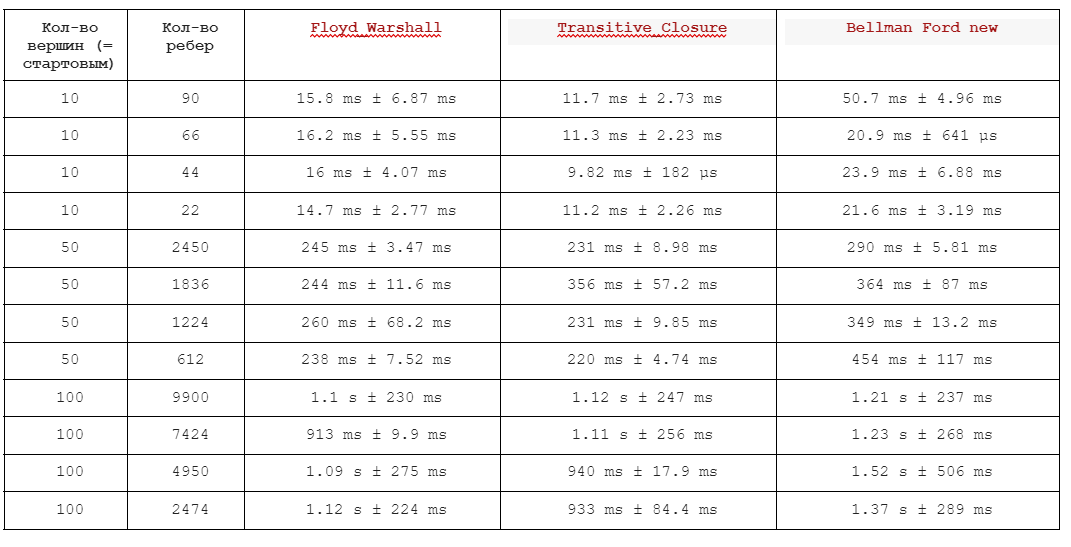


Полные результаты тестирования алгоритмов по [ссылке](https://docs.google.com/document/d/1HkwUq6W-e53jyKa7eXlu_3q2DDyeHIq-EZs9QGwxaBA/edit?usp=sharing).

**Выводы:**
1. Судя по тестированию на реальных графах быстрее всего работает алгоритм транзитивного замыкания, что обосновано облегчением вычислений с помощью единичной матрицы. Второй по скорости Алгоритм Флойда Варшалла и затем уже модифицированный алгоритм Форда Баллмана.
2. При тестирование на случайно сгенерированных графов скорость работы алгоритмов такая же. Тестирование проводилась на графах с 100 вершинами максимум.
3. Быстрее всего алгоритмы отрабатывают на разряженном графе, где матрица заполнена менее, чем на 25%. При этом на совсем малых графах (до 50 вершин) практически таже быстро алгоритмы Флойда Варшалла и транзитивного замыкания работают на неразряженном графе, то есть на полностью заполненной матрице, где каждая вершина соединена с каждой. В алгоритме Форда Баллмана такой тенденции не выявлено.